## 1. План работы
1. Анализ и подготовка данных. Изучить данные, найти неточности, пропуски, удаление аномалий, заполнение пропусков, соединение таблиц, расчет дополнительных показателей.
2. Построение и обучение моделей. Обучение различных моделей.
3. Сравнение результатов обучения и выбор лучшей модели.

## 2. Анализ данных и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb
from sklearn.linear_model import LinearRegression

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

In [2]:
data_arc = pd.read_csv()
data_arc.columns = ['key', 'start_of_arc_heating', 'end_of_arc_heating', 'active_power', 'reactive_power']
data_arc.info()
data_arc.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
start_of_arc_heating    14876 non-null object
end_of_arc_heating      14876 non-null object
active_power            14876 non-null float64
reactive_power          14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Приведем столбцы к нужному формату

In [3]:
data_arc['start_of_arc_heating'] = pd.to_datetime(data_arc['start_of_arc_heating'])
data_arc['end_of_arc_heating'] = pd.to_datetime(data_arc['end_of_arc_heating'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
start_of_arc_heating    14876 non-null datetime64[ns]
end_of_arc_heating      14876 non-null datetime64[ns]
active_power            14876 non-null float64
reactive_power          14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Проверим колонки на пропуски

In [4]:
data_arc.isna().sum()

key                     0
start_of_arc_heating    0
end_of_arc_heating      0
active_power            0
reactive_power          0
dtype: int64

Посмотрим на распределение мощностей

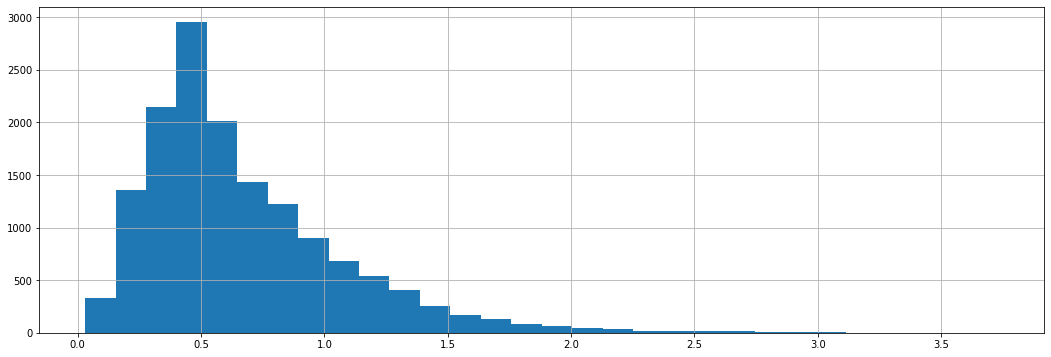

In [5]:
data_arc['active_power'].hist(figsize=(18, 6), bins=30)
plt.show()

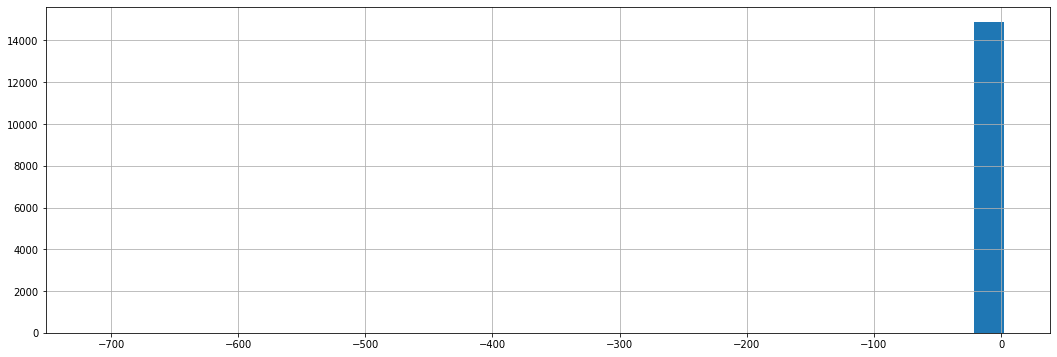

In [6]:
data_arc['reactive_power'].hist(figsize=(18, 6), bins=30)
plt.show()

Как видно в реактивной мощности есть аномалии, посмотрим на это значение

In [7]:
data_arc['reactive_power'].sort_values()

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: reactive_power, Length: 14876, dtype: float64

Удалим это значение для корректности данных

In [8]:
data_arc = data_arc.drop(index=[9780]).reset_index()

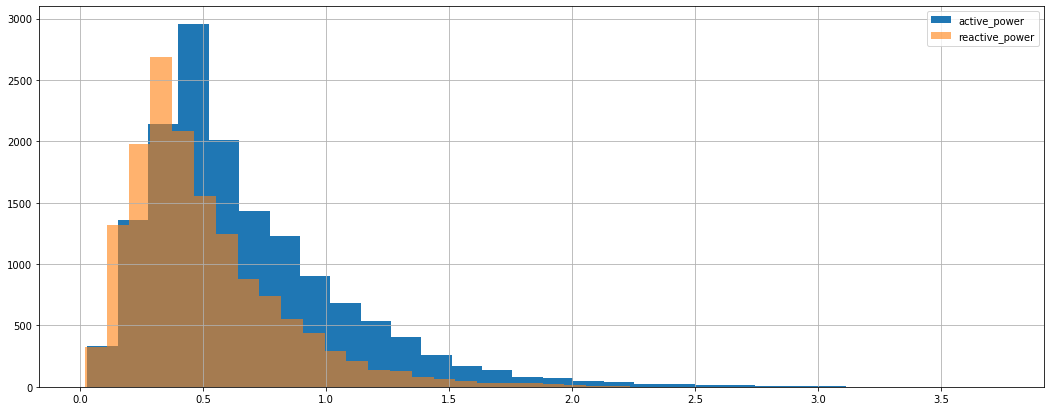

In [9]:
data_arc['active_power'].hist(bins=30, label='active_power')
data_arc['reactive_power'].hist(figsize=(18, 7), alpha = 0.6, bins=30, label='reactive_power')
plt.legend()
plt.show()

Теперь данные имуют корректный вид

Дополнительно выделим данные по средним значениям и сумме по стадиям

In [10]:
arc_pivot = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc='mean')
arc_pivot.columns = ['act_pow_mean', 'react_pow_mean']
arc_pivot

,act_pow_mean,react_pow_mean
key,,
1,0.975629,0.636648
2,0.763150,0.499528
3,0.505176,0.319815
4,0.802313,0.515074
5,0.836793,0.563161
...,...,...
3237,0.786493,0.565692
3238,0.702176,0.560394
3239,0.583344,0.388952


In [11]:
arc_pivot_sum = data_arc.pivot_table(index='key', values=['active_power', 'reactive_power'], aggfunc='sum')
arc_pivot_sum.columns = ['act_pow_sum', 'react_pow_sum']
arc_pivot_sum

,act_pow_sum,react_pow_sum
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


In [12]:
arc_pivot_count = data_arc.pivot_table(index='key', values='active_power', aggfunc='count')
arc_pivot_count.columns = ['iteracion']
arc_pivot_count

,iteracion
key,
1,5
2,4
3,5
4,4
5,4
...,...
3237,5
3238,3
3239,8


In [13]:
data_bulk = pd.read_csv()
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
data_bulk_time = pd.read_csv()
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [15]:
data_gas = pd.read_csv()
data_gas.columns = ['key', 'gas']
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Проверим данные на пропуски

In [16]:
data_gas.isna().sum()

key    0
gas    0
dtype: int64

In [17]:
data_temp = pd.read_csv()
data_temp.columns = ['key', 'measurement_time', 'temp']
data_temp.info()
data_temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key                 15907 non-null int64
measurement_time    15907 non-null object
temp                13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Исправим тип данных столбцов

In [18]:
data_temp['measurement_time'] = pd.to_datetime(data_temp['measurement_time'])

Проверим данные на пропуски

In [19]:
data_temp.isna().sum()

key                    0
measurement_time       0
temp                2901
dtype: int64

Также посмотрим на распределение температуры

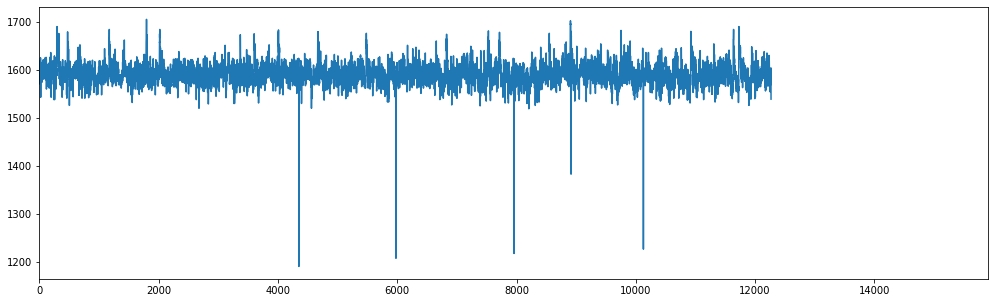

In [20]:
plt.figure(figsize=(17, 5))
data_temp['temp'].plot()

Также заметим, что есть выбросы, удалим их, так же как и партии с пропущенными значениями

Заполним пропуски "ключем", чтобы посмотреть, откуда начинаются пропуски.

In [21]:
data_temp_new = data_temp.fillna(112233)
data_temp_key = data_temp_new.query('temp == 112233')
data_temp_key

,key,measurement_time,temp
12268,2500,2019-08-06 03:24:43,112233.0
12269,2500,2019-08-06 03:25:16,112233.0
12270,2500,2019-08-06 03:28:21,112233.0
12272,2501,2019-08-06 04:01:59,112233.0
12273,2501,2019-08-06 04:14:35,112233.0
...,...,...,...
15901,3240,2019-09-01 03:35:16,112233.0
15903,3241,2019-09-01 04:16:12,112233.0
15904,3241,2019-09-01 04:22:39,112233.0
15905,3241,2019-09-01 04:33:42,112233.0


Пропущенные значения идут после 2500 партии или 12268 индекса

Теперь мы можем удалить пропущенные данные, включая партию, и выбросы

In [22]:
data_temp = data_temp.query('key < 2500')
data_temp = data_temp.query('temp > 1500')
data_temp

,key,measurement_time,temp
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [23]:
data_wire = pd.read_csv()
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Перейдем к объединению таблиц, будем использовать метод `merge`, объединять будем не все таблицы, исключим `data_wire_time` и `data_bulk_time`

In [47]:
data_merge = data_arc[['key', 'start_of_arc_heating']].drop_duplicates(subset='key', keep='first').merge(arc_pivot, on='key')
data_merge = data_merge. merge(data_arc[['key', 'end_of_arc_heating']].drop_duplicates(subset='key', keep='last'), on='key')
data_merge = data_merge.merge(arc_pivot_sum, on='key')
data_merge = data_merge.merge(data_temp.drop_duplicates(subset='key', keep='first'), on='key')
data_merge = data_merge.merge(data_gas, on='key')
data_merge = data_merge.merge(data_wire, on='key')
data_merge = data_merge.merge(data_bulk, on='key')
data_merge = data_merge.merge(arc_pivot_count, on='key')

In [48]:
# пропущенные значения заполним 0, он не повлияет на результатирующую метрику
data_merge.fillna(0, inplace=True)

In [49]:
data_merge.head()

,key,start_of_arc_heating,act_pow_mean,react_pow_mean,end_of_arc_heating,act_pow_sum,react_pow_sum,measurement_time,temp,gas,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,iteracion
0,1,2019-05-03 11:02:14,0.975629,0.636648,2019-05-03 11:28:37,4.878147,3.183241,2019-05-03 11:16:18,1571.0,29.749986,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,5
1,2,2019-05-03 11:34:14,0.763150,0.499528,2019-05-03 11:53:18,3.052598,1.998112,2019-05-03 11:37:27,1581.0,12.555561,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,2019-05-03 12:06:54,0.505176,0.319815,2019-05-03 12:32:19,2.525882,1.599076,2019-05-03 12:13:17,1596.0,28.554793,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,5
3,4,2019-05-03 12:39:37,0.802313,0.515074,2019-05-03 12:57:50,3.209250,2.060298,2019-05-03 12:52:57,1601.0,18.841219,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,2019-05-03 13:11:13,0.836793,0.563161,2019-05-03 13:33:55,3.347173,2.252643,2019-05-03 13:23:19,1576.0,5.413692,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


Создадим дополнительные признаки для лучшего обучения моделей

In [50]:
# суммарная продолжительность нагрева в секундах
data_merge['duration_of_heating'] = data_merge['end_of_arc_heating'] - data_merge['start_of_arc_heating']
data_merge['duration_of_heating'] = data_merge['duration_of_heating'].dt.total_seconds()

# время первого замера температуры в секундах 
data_merge['first_measuring_time'] = data_merge['measurement_time'] - data_merge['start_of_arc_heating']
data_merge['first_measuring_time'] = data_merge['first_measuring_time'].dt.total_seconds()

# разница активной и реактивной мощности, средняя, сколько тратиться мощности на нагрев
data_merge['raznica_pow_mean'] = data_merge['act_pow_mean'] - data_merge['react_pow_mean']

# таргет
data_merge = data_merge.merge(data_temp[['key', 'temp']].drop_duplicates(subset='key', keep='last'), on='key')

# формула полной мощности через активную и реактивную мощность
data_merge['temp_formula'] = data_merge['temp_x'] / (((data_merge['act_pow_sum']**2) + (data_merge['react_pow_sum']**2))**0.5)
data_merge

,key,start_of_arc_heating,act_pow_mean,react_pow_mean,end_of_arc_heating,act_pow_sum,react_pow_sum,measurement_time,temp_x,gas,...,Bulk 12,Bulk 13,Bulk 14,Bulk 15,iteracion,duration_of_heating,first_measuring_time,raznica_pow_mean,temp_y,temp_formula
0,1,2019-05-03 11:02:14,0.975629,0.636648,2019-05-03 11:28:37,4.878147,3.183241,2019-05-03 11:16:18,1571.0,29.749986,...,206.0,0.0,150.0,154.0,5,1583.0,844.0,0.338981,1613.0,269.704689
1,2,2019-05-03 11:34:14,0.763150,0.499528,2019-05-03 11:53:18,3.052598,1.998112,2019-05-03 11:37:27,1581.0,12.555561,...,206.0,0.0,149.0,154.0,4,1144.0,193.0,0.263622,1602.0,433.340909
2,3,2019-05-03 12:06:54,0.505176,0.319815,2019-05-03 12:32:19,2.525882,1.599076,2019-05-03 12:13:17,1596.0,28.554793,...,205.0,0.0,152.0,153.0,5,1525.0,383.0,0.185361,1599.0,533.868101
3,4,2019-05-03 12:39:37,0.802313,0.515074,2019-05-03 12:57:50,3.209250,2.060298,2019-05-03 12:52:57,1601.0,18.841219,...,207.0,0.0,153.0,154.0,4,1093.0,800.0,0.287238,1625.0,419.805108
4,5,2019-05-03 13:11:13,0.836793,0.563161,2019-05-03 13:33:55,3.347173,2.252643,2019-05-03 13:23:19,1576.0,5.413692,...,203.0,0.0,151.0,152.0,4,1362.0,726.0,0.273633,1602.0,390.621520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-06 00:31:05,0.802673,0.590194,2019-08-06 00:51:13,3.210690,2.360777,2019-08-06 00:35:45,1570.0,7.125735,...,256.0,0.0,129.0,223.0,4,1208.0,280.0,0.212478,1591.0,393.957910
2325,2496,2019-08-06 01:00:06,0.700511,0.468364,2019-08-06 01:23:32,4.203064,2.810185,2019-08-06 01:02:54,1554.0,9.412616,...,256.0,0.0,129.0,226.0,6,1406.0,168.0,0.232147,1591.0,307.359076
2326,2497,2019-08-06 01:38:01,0.737460,0.617090,2019-08-06 01:50:45,2.212379,1.851269,2019-08-06 01:41:53,1571.0,6.271699,...,230.0,0.0,124.0,226.0,3,764.0,232.0,0.120370,1589.0,544.586747
2327,2498,2019-08-06 01:57:46,0.681745,0.471086,2019-08-06 02:20:24,3.408725,2.355428,2019-08-06 02:03:49,1591.0,14.953657,...,206.0,0.0,129.0,207.0,5,1358.0,363.0,0.210659,1594.0,383.987660


Проверим наши признаки на мультиколлинеарность, и если у нас она есть, то удалим часть признаков, которые меньше скоррелированы с таргетом.

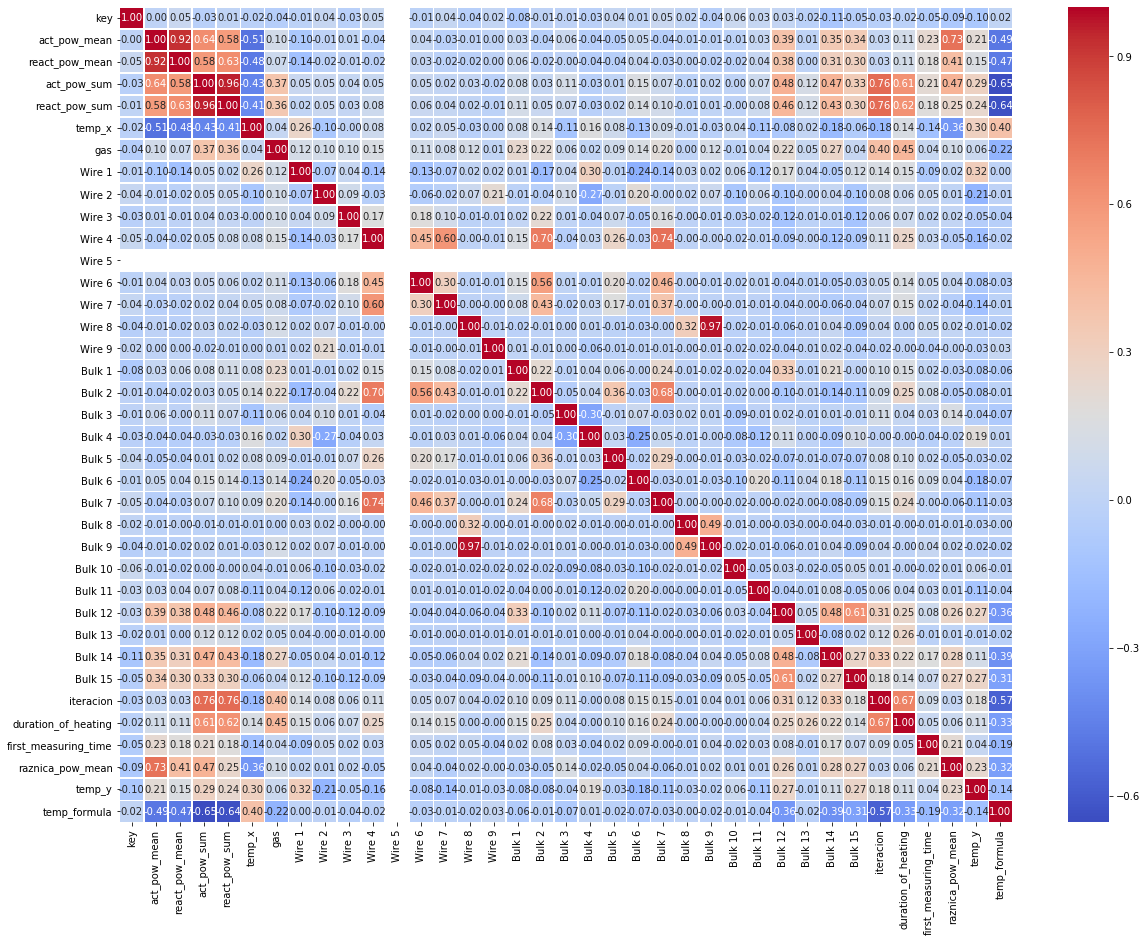

In [51]:
plt.figure(figsize=(20,15))
sns.heatmap(data_merge.corr(), annot=True, fmt=".2f", linewidths=.5, cmap= 'coolwarm') 

Удалим признаки `react_pow_mean`, `react_pow_sum` и `Wire 8`

In [52]:
data_merge = data_merge.drop(['react_pow_mean', 'react_pow_sum', 'Wire 8'], axis=1)
data_merge

,key,start_of_arc_heating,act_pow_mean,end_of_arc_heating,act_pow_sum,measurement_time,temp_x,gas,Wire 1,Wire 2,...,Bulk 12,Bulk 13,Bulk 14,Bulk 15,iteracion,duration_of_heating,first_measuring_time,raznica_pow_mean,temp_y,temp_formula
0,1,2019-05-03 11:02:14,0.975629,2019-05-03 11:28:37,4.878147,2019-05-03 11:16:18,1571.0,29.749986,60.059998,0.00000,...,206.0,0.0,150.0,154.0,5,1583.0,844.0,0.338981,1613.0,269.704689
1,2,2019-05-03 11:34:14,0.763150,2019-05-03 11:53:18,3.052598,2019-05-03 11:37:27,1581.0,12.555561,96.052315,0.00000,...,206.0,0.0,149.0,154.0,4,1144.0,193.0,0.263622,1602.0,433.340909
2,3,2019-05-03 12:06:54,0.505176,2019-05-03 12:32:19,2.525882,2019-05-03 12:13:17,1596.0,28.554793,91.160157,0.00000,...,205.0,0.0,152.0,153.0,5,1525.0,383.0,0.185361,1599.0,533.868101
3,4,2019-05-03 12:39:37,0.802313,2019-05-03 12:57:50,3.209250,2019-05-03 12:52:57,1601.0,18.841219,89.063515,0.00000,...,207.0,0.0,153.0,154.0,4,1093.0,800.0,0.287238,1625.0,419.805108
4,5,2019-05-03 13:11:13,0.836793,2019-05-03 13:33:55,3.347173,2019-05-03 13:23:19,1576.0,5.413692,89.238236,9.11456,...,203.0,0.0,151.0,152.0,4,1362.0,726.0,0.273633,1602.0,390.621520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-06 00:31:05,0.802673,2019-08-06 00:51:13,3.210690,2019-08-06 00:35:45,1570.0,7.125735,89.150879,0.00000,...,256.0,0.0,129.0,223.0,4,1208.0,280.0,0.212478,1591.0,393.957910
2325,2496,2019-08-06 01:00:06,0.700511,2019-08-06 01:23:32,4.203064,2019-08-06 01:02:54,1554.0,9.412616,114.179527,0.00000,...,256.0,0.0,129.0,226.0,6,1406.0,168.0,0.232147,1591.0,307.359076
2326,2497,2019-08-06 01:38:01,0.737460,2019-08-06 01:50:45,2.212379,2019-08-06 01:41:53,1571.0,6.271699,94.086723,9.04800,...,230.0,0.0,124.0,226.0,3,764.0,232.0,0.120370,1589.0,544.586747
2327,2498,2019-08-06 01:57:46,0.681745,2019-08-06 02:20:24,3.408725,2019-08-06 02:03:49,1591.0,14.953657,118.110717,0.00000,...,206.0,0.0,129.0,207.0,5,1358.0,363.0,0.210659,1594.0,383.987660


## 3. Построение и обучение моделей

Выделим признаки и таргет

In [32]:
features = data_merge.drop(
    ['key', 'temp_y', 'start_of_arc_heating', 'end_of_arc_heating', 'measurement_time'], axis=1)
target = data_merge['temp_y']

In [33]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=42)

In [34]:
# DataFrame для внесения результатов моделей
mod_columns = {'model':[],'MAE train':[],'MAE valid':[]}
model_results = pd.DataFrame(mod_columns)

Обучим различные модели и выберем лучшую

In [35]:
model = RandomForestRegressor(random_state=12345, n_estimators=150, max_depth=15)
model.fit(features_train, target_train)

predict_train_forest = '{:.3f}'.format(mean_absolute_error(target_train, model.predict(features_train)))
predict_valid_forest = '{:.3f}'.format(mean_absolute_error(target_valid, model.predict(features_valid)))

row_forest = {'model':'RandomForestRegressor', 'MAE train':predict_train_forest, 'MAE valid':predict_valid_forest}
model_results = model_results.append(row_forest, ignore_index=True)

In [36]:
model_lin = LinearRegression()
model_lin.fit(features_train, target_train)

predict_train_linear = '{:.3f}'.format(mean_absolute_error(target_train, model_lin.predict(features_train)))
predict_valid_linear = '{:.3f}'.format(mean_absolute_error(target_valid, model_lin.predict(features_valid)))

row_linear = {'model':'LinearRegression', 'MAE train':predict_train_linear, 'MAE valid':predict_valid_linear}
model_results = model_results.append(row_linear, ignore_index=True)

In [37]:
model_lgbm = ltb.LGBMRegressor(random_state=54, n_estimators=200, learning_rate=.03)
model_lgbm.fit(features_train, target_train)

predict_train_lgbm = '{:.3f}'.format(mean_absolute_error(target_train, model_lgbm.predict(features_train)))
predict_valid_lgbm = '{:.3f}'.format(mean_absolute_error(target_valid, model_lgbm.predict(features_valid)))

row_linear = {'model':'LGBMRegressor', 'MAE train':predict_train_lgbm, 'MAE valid':predict_valid_lgbm}
model_results = model_results.append(row_linear, ignore_index=True)

In [38]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV
#model_test = ltb.LGBMRegressor(random_state=1)
#model_test = CatBoostRegressor(random_seed=1)
#parametrs = { 'n_estimators': range (1000, 3000, 100),
#             'max_depth': range (1, 13, 2)}
#gsc = RandomizedSearchCV(model_test, parametrs, scoring='neg_mean_absolute_error', cv=3, verbose=1)
#gsc.fit(features_train, target_train)
#gsc.best_params_

In [39]:
model_cat = CatBoostRegressor(random_seed=1242, n_estimators=2300, max_depth=5) #, learning_rate=0.03)
model_cat.fit(features_train, target_train, verbose=2)

predict_train_cat = '{:.3f}'.format(mean_absolute_error(target_train, model_cat.predict(features_train)))
predict_valid_cat = '{:.3f}'.format(mean_absolute_error(target_valid, model_cat.predict(features_valid)))

row_linear = {'model':'CatBoostRegressor', 'MAE train':predict_train_cat, 'MAE valid':predict_valid_cat}
model_results = model_results.append(row_linear, ignore_index=True)

0:	learn: 11.0685597	total: 49.4ms	remaining: 1m 53s
2:	learn: 10.9220226	total: 53.1ms	remaining: 40.7s
4:	learn: 10.7589825	total: 59.2ms	remaining: 27.2s
6:	learn: 10.6107079	total: 129ms	remaining: 42.4s
8:	learn: 10.4644646	total: 133ms	remaining: 33.8s
10:	learn: 10.3314677	total: 136ms	remaining: 28.3s
12:	learn: 10.2147727	total: 225ms	remaining: 39.6s
14:	learn: 10.0946847	total: 229ms	remaining: 34.8s
16:	learn: 9.9805449	total: 236ms	remaining: 31.6s
18:	learn: 9.8619626	total: 322ms	remaining: 38.7s
20:	learn: 9.7642522	total: 326ms	remaining: 35.4s
22:	learn: 9.6647241	total: 329ms	remaining: 32.6s
24:	learn: 9.5727732	total: 343ms	remaining: 31.2s
26:	learn: 9.5031103	total: 422ms	remaining: 35.5s
28:	learn: 9.4007634	total: 425ms	remaining: 33.3s
30:	learn: 9.3142238	total: 433ms	remaining: 31.7s
32:	learn: 9.2320724	total: 522ms	remaining: 35.9s
34:	learn: 9.1642026	total: 526ms	remaining: 34.1s
36:	learn: 9.0894755	total: 536ms	remaining: 32.8s
38:	learn: 9.0192005	tot

## 4. Сравнение результатов обучения и выбор лучшей модели

Посмотрим на результаты работы наших моделей

In [40]:
model_results

,model,MAE train,MAE valid
0,RandomForestRegressor,2.336,5.935
1,LinearRegression,5.376,5.776
2,LGBMRegressor,3.023,5.786
3,CatBoostRegressor,2.155,5.715


Как видно CatBoostRegressor показал лучший результат

Посмотрим на важность распределения признаков в модели CatBoostRegressor

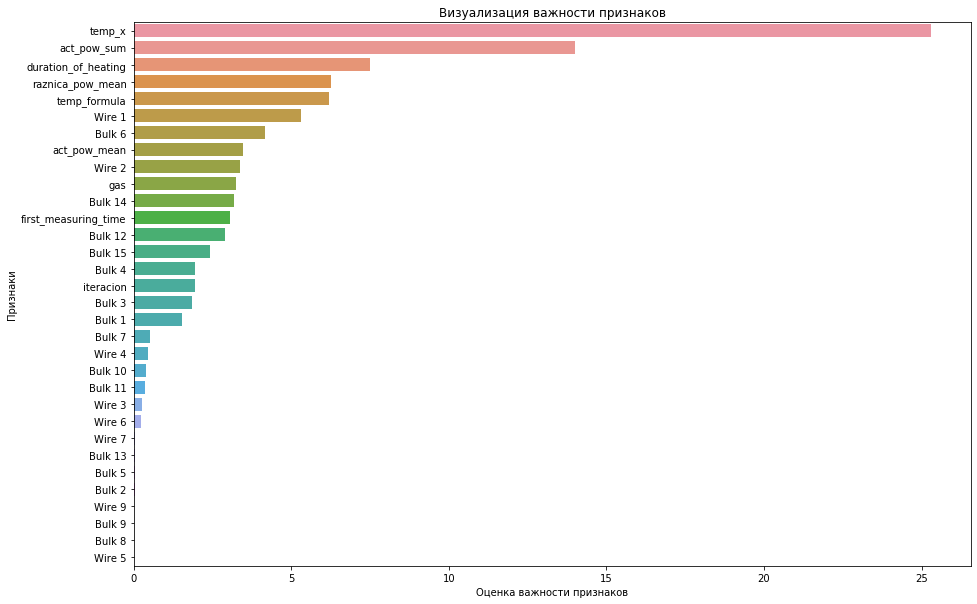

In [41]:
plt.figure(figsize=(15, 10))
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(model_cat)

Самая высокая важность у начальной температуры, а затем идёт много "синтетических" признаков, которые мы добавили сами.

## 5. Отчет

 <div style="background; padding: 5px; border: 1px solid; border-radius: 5px;">
<br/>
<b>Перед нами стояла задача создать модель, которая будет предсказывать температуру стали, для экономии электроэнергии и денежных средств предприятия.</b>
    
<br/><b>План работы был следующий:</b><br/>
    <br/>1. Проанализировать и подготовить полученные данные;
    <br/>2. Построить и обучить модели;
    <br/>3. Выбрать лучшую из моделей.
    
<br/><b>1. Этап</b>
- Проанализировав данные были найдены выбросы в файлах `data_arc.csv` и `data_temp.csv`. Выбросы были удалены, чтобы не влияли негативно на показатели моделей.
- Также в таблице `data_temp.csv` отсутствовали часть значений, они были удалены. 
- Были построены дополнительные таблицы для добавления в признаки. 
- В итоге все данные для признаков были соеденины в одну общую таблицу, затем были проверены на мультиколлинеарность, в следствии чего было удалено 3 признака из пар признаков сильно коллерирующих друг с другом.
    
<br/><b>2. Этап</b>
- Разделили данные на признаки и целевой признак.
- Для обучения были выбраны 4 модели: RandomForestRegressor, LinearRegression, LGBMRegressor, CatBoostRegressor.
    
<br/><b>3. Этап</b>
- Среди всех обученных моделей самый лучший результать показала CatBoostRegressor, с MAE = 5.715.
- При обучении CatBoostRegressor самым важным для неё признаком была начальная температура стали поступающей на обработку. Следом "идёт" суммарная активная мощность в партии, а затем продолжительность нагрева.